In [1]:
from products.snow_cover_product import MeteoFranceEvalSNPP, MeteoFrancePrototypeSNPP, VNP10A1, VJ110A1
from postprocess.general_purpose import AnalysisContainer
from winter_year import WinterYear
from grids import UTM375mGrid
from postprocess.general_purpose import AnalysisContainer

analysis = AnalysisContainer(products = [MeteoFrancePrototypeSNPP(), VNP10A1(), VJ110A1()], 
                             analysis_folder = '/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/',
                             winter_year=WinterYear(2023,2024),
                             grid=UTM375mGrid())


In [9]:
from typing import List
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from postprocess.error_distribution import line_plot_rmse, plot_custom_spans
import matplotlib.patches as mpatches
from postprocess.skill_scores import line_plot_accuracy_f1_score, line_plot_total_count


def plot_one_var_analysis(analysis: AnalysisContainer, analysis_var:str, axs: List[Axes]):
        titles_dict = { "Ref FSC [%]": "Reference FSC","Aspect": "Aspect", "Landcover": "Landcover", "Slope [°]": "Slope", "View Zenith Angle [°]": "View Zenith Angle"} 
        
        axs[0].set_title(titles_dict[analysis_var], fontweight="bold", fontsize=12)
        line_plot_accuracy_f1_score(analysis=analysis, analysis_var=analysis_var,ax=axs[0])
        line_plot_rmse(analysis=analysis,analysis_var=analysis_var,ax=axs[1])
        plot_custom_spans(analysis=analysis,analysis_var=analysis_var, ax=axs[2])
        line_plot_total_count(analysis=analysis,analysis_var=analysis_var, ax=axs[-1])
def plot_grid(analysis: AnalysisContainer, params_list:List[str], axs: List[Axes]):

    analysis_sza = AnalysisContainer(products = [MeteoFrancePrototypeSNPP()], 
                                analysis_folder = '/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8_sensor_zenith/',
                                winter_year=WinterYear(2023,2024),
                                grid=UTM375mGrid())
    for i, var in enumerate(params_list):
        if var=="View Zenith Angle [°]":
            plot_one_var_analysis(analysis=analysis_sza,
                                  analysis_var=var,
                                  axs=axs[:,i])
        else:
            plot_one_var_analysis(analysis, var, axs[:,i])



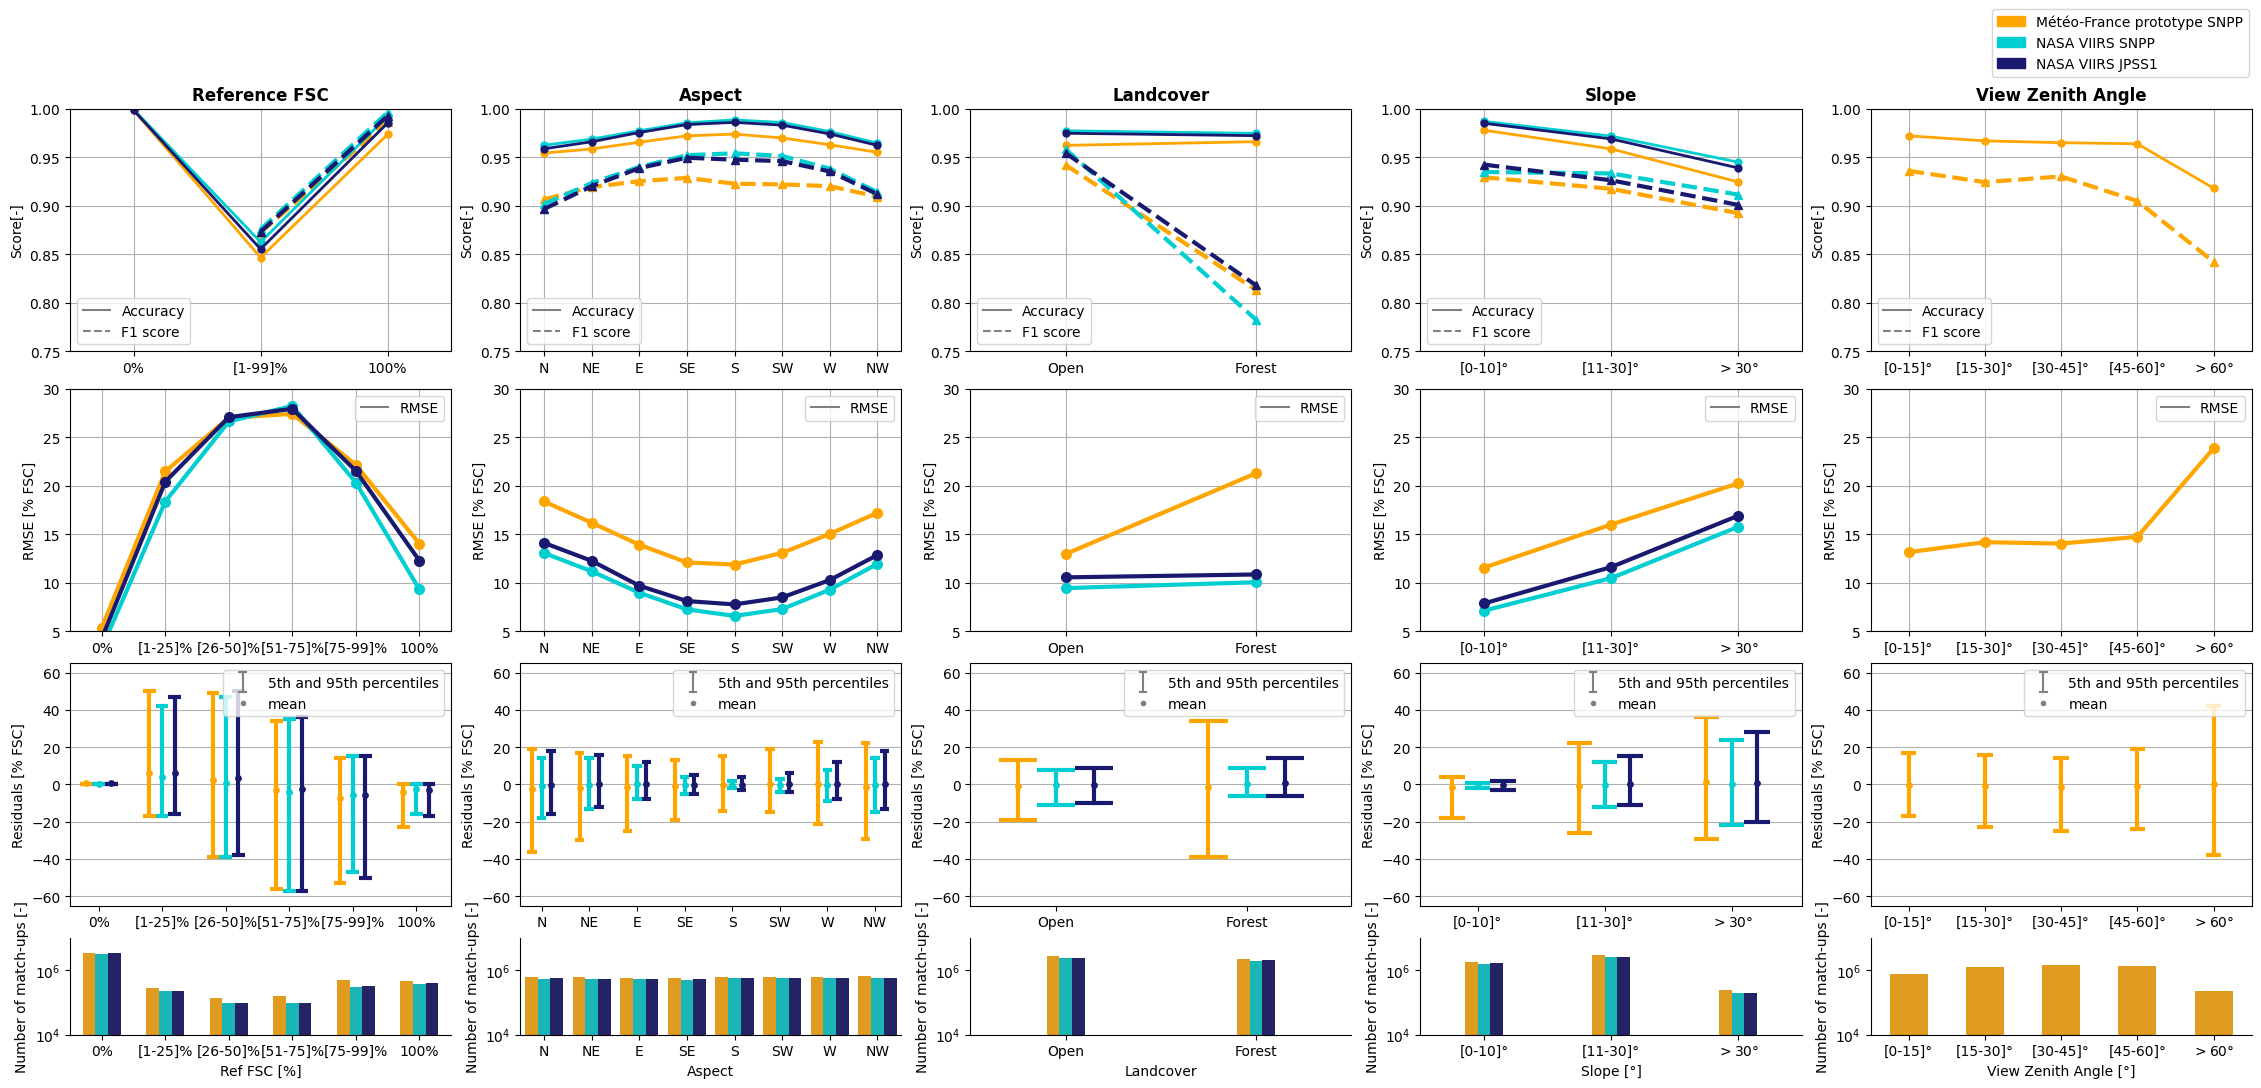

In [10]:
params = ["Ref FSC [%]","Aspect", "Landcover", "Slope [°]","View Zenith Angle [°]"] 
fig, axs = plt.subplots(4, len(params), figsize=(4.5  * len(params), 10), layout="constrained",gridspec_kw={'height_ratios':[2,2,2,0.8]})
plot_grid(analysis=analysis,params_list=params, axs=axs)
custom_leg = [
        mpatches.Patch(color=product.plot_color, label=product.plot_name)
        for product in analysis.products
    ]
fig.legend(handles=custom_leg, bbox_to_anchor=(1,1.08))
fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/article/synthesis_scores_plot.png', format='png',bbox_inches='tight')

<>:5: SyntaxWarning: invalid escape sequence '\%'
<>:5: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_30802/519280429.py:5: SyntaxWarning: invalid escape sequence '\%'
  params = ["Ref FSC [\%]","Aspect", "Landcover", "Slope [°]"]


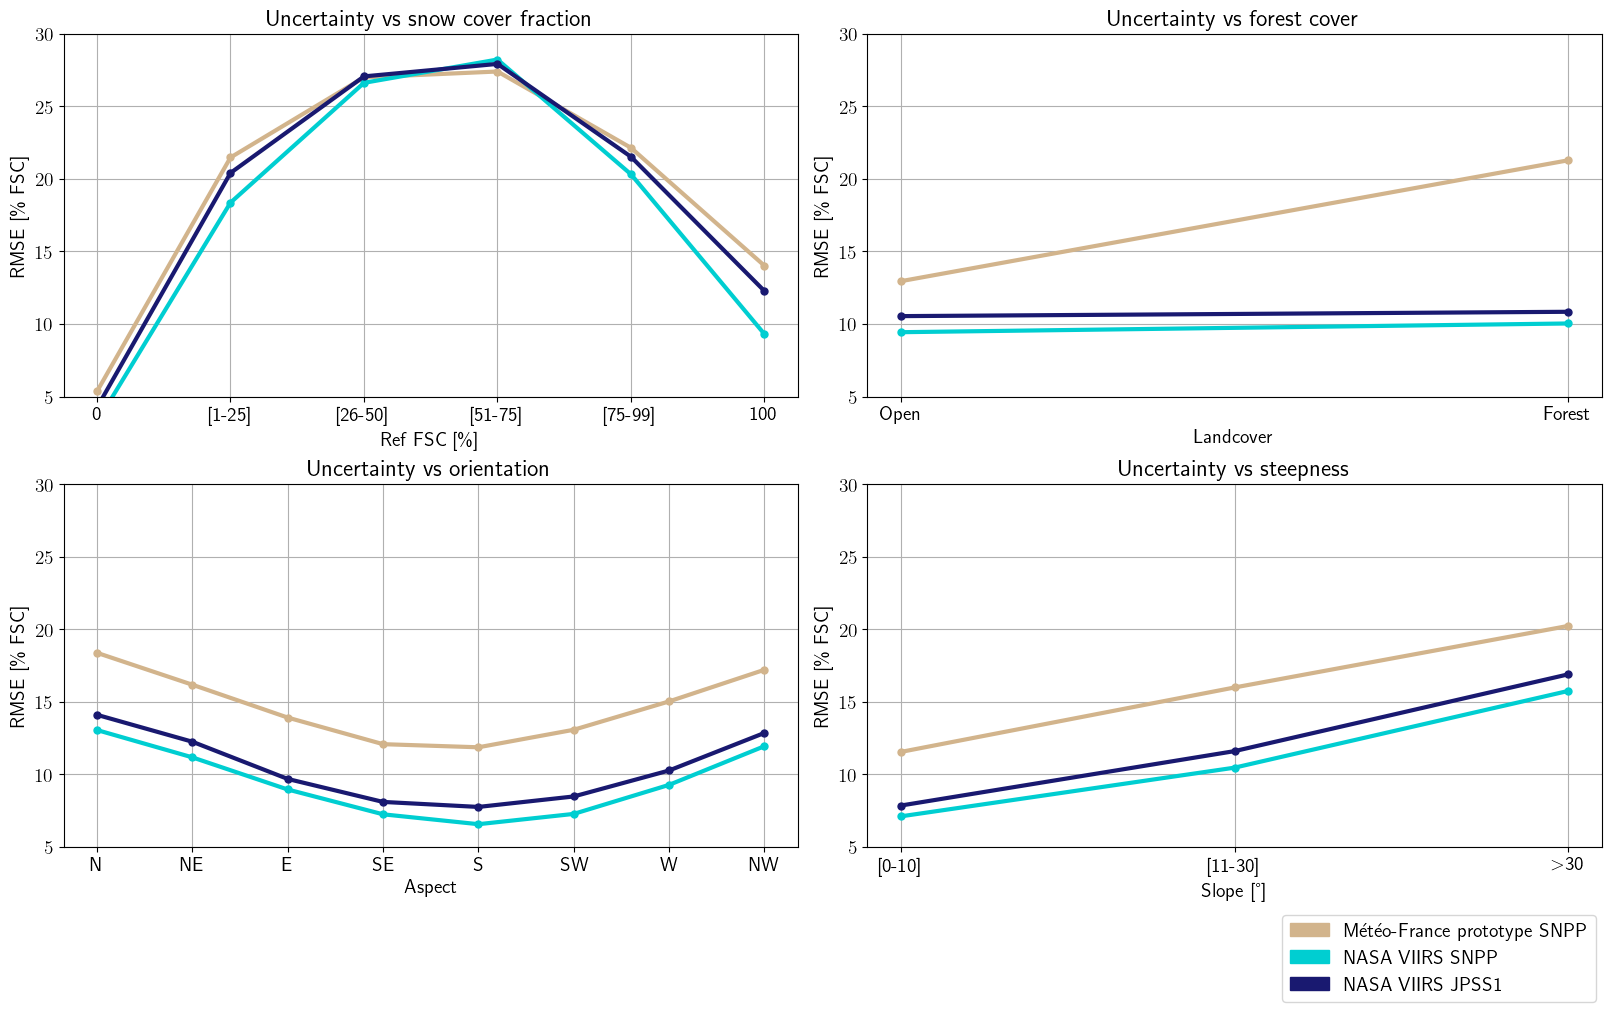

In [6]:
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 14
})
params = ["Ref FSC [\%]","Aspect", "Landcover", "Slope [°]"] 
fig, axs = plt.subplots(2, 2, figsize=(16,9), layout="constrained")
line_plot_rmse(analysis=analysis, analysis_var=params[0],ax=axs[0][0])
line_plot_rmse(analysis=analysis, analysis_var=params[2],ax=axs[0][1])
line_plot_rmse(analysis=analysis, analysis_var=params[1],ax=axs[1][0])
line_plot_rmse(analysis=analysis, analysis_var=params[3],ax=axs[1][1])
custom_leg = [
        mpatches.Patch(color=product.plot_color, label=product.plot_name)
        for product in analysis.products
    ]
[ax.get_legend().remove() for ax in axs.flatten()]

axs[0][0].set_title('Uncertainty vs snow cover fraction',fontweight="bold")
axs[0][1].set_title('Uncertainty vs forest cover',fontweight="bold")
axs[1][0].set_title('Uncertainty vs orientation',fontweight="bold")
axs[1][1].set_title('Uncertainty vs steepness',fontweight="bold")
fig.legend(handles=custom_leg, bbox_to_anchor=(1,-0))
# fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/article/rmse_synthesis.svg', format='svg',bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

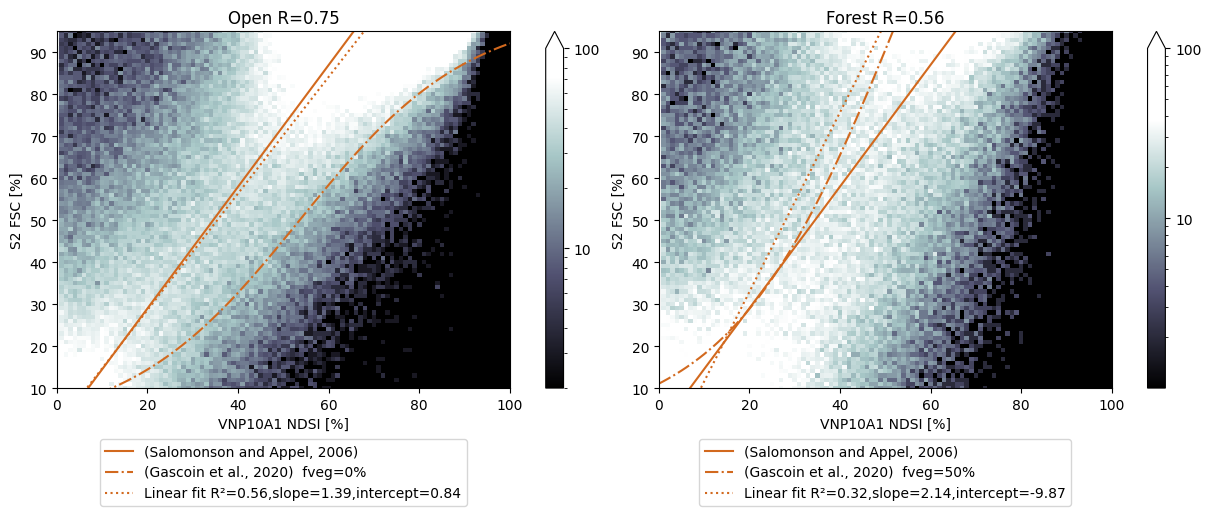

In [3]:

### NDSI-FSC regression
from matplotlib import cm, colors
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import numpy as np
from fractional_snow_cover import gascoin, salomonson_appel
# from postprocess.scatter_plot import fancy_scatter_plot
import xarray as xr
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr
from postprocess.scatter_plot import compute_correlation_coefficient_from_weights, fancy_scatter_plot_with_fit
analysis_type = "scatter"
analysis_folder = (
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/analyses/"
)

nasa_l3_snpp_metrics_ds = xr.open_dataset(
    f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp_vs_S2_theia.nc"
)


plt.subplots_adjust(bottom=0.18)
fig, ax = plt.subplots(1,2, figsize=(12, 5), sharex=True, layout="constrained")



FOREST_TITLE = {'no_forest': 'Open', 'forest': 'Forest'}
for i, fore in enumerate(["no_forest", "forest"]):

    n_min = 0
    # fig.suptitle("VNP10A1 NDSI_Snow_Cover vs Reference FSC (Sentinel-2)", fontsize=14)
    reduced = (
        nasa_l3_snpp_metrics_ds.sel(
            ref_bins=slice(10, 95),
            forest_mask_bins=[fore],
            test_bins=slice(0, 100),
        )
        .sum(dim=("forest_mask_bins", "time", "altitude_bins"))
        .data_vars["n_occurrences"]
    )

    xax = reduced.test_bins.values
    f_veg=0 if fore=="no_forest" else 0.5
    fit_g = gascoin(xax * 0.01, f_veg=f_veg) * 100

    ax[i].plot(xax, salomonson_appel(xax), color="chocolate", linewidth=1.5, label="(Salomonson and Appel, 2006)")
    ax[i].plot(xax, fit_g,"-.",color="chocolate", linewidth=1.5, label=f"(Gascoin et al., 2020)  fveg={int(f_veg*100)}%")

    scatter_plot = fancy_scatter_plot_with_fit(
        data_to_plt=reduced.rename({"ref_bins": "y", "test_bins": "x"}),
        ax=ax[i],
        figure=fig,
        low_threshold=None,
        smoothing_window_size=None,
    )

    pcc = compute_correlation_coefficient_from_weights(reduced.rename({"ref_bins": "y", "test_bins": "x"}))
    # ax[i].set_title(PRODUCT_PLOT_NAMES[k])
    ax[i].set_ylabel("S2 FSC [%]")
    ax[i].set_xlabel("VNP10A1 NDSI [%]")
    ax[i].set_title(f"{FOREST_TITLE[fore]} R={pcc:.2f}", fontsize=12)
    # ax[i].set_title(f"{FOREST_TITLE[fore]} R={pcc:.2f}", fontsize=14)
    ax[i].set_ylim(10,95)
    ax[i].set_xlim(0,100)


plt.show()

fig.patch.set_alpha(0.0)
fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/article/scatter_plot.png', format='png',bbox_inches='tight')

In [ ]:
from matplotlib import patches, ticker
from postprocess.error_distribution import postprocess_uncertainty_analysis
from postprocess.general_purpose import open_reduced_dataset, open_reduced_dataset_completeness
from postprocess.general_purpose import AnalysisContainer
from typing import List
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np

def plot_annual_area_lines(analysis: AnalysisContainer, classes: List[str] , axes: List[Axes]):
    class_titles = {'snow_cover': 'Snow cover', 'clouds': 'Clouds'}
    class_ylim_top={'snow_cover': 2e4, 'clouds': 6e4}
    for product in analysis.products:
        metrics_dataset_completeness = open_reduced_dataset_completeness(product=product, analysis_folder=analysis_folder, winter_year=analysis.winter_year, grid=analysis.grid).sel(
            time=slice(f"{analysis.winter_year.from_year}-11", f"{analysis.winter_year.to_year}-06"), altitude_bins=slice(900, None)
        )
        product_monthly_averages = (
            metrics_dataset_completeness.resample({"time": "1ME"}).mean(dim="time").data_vars["surface"] * 1e-6
        )
        product_monthly_averages = product_monthly_averages.sum(
            dim=[d for d in product_monthly_averages.dims if d != "time" and d != "class_name"]
        )

        time_ax = np.arange(product_monthly_averages.sizes["time"])
        
        for i,area_class in enumerate(classes):
            annual_surface = product_monthly_averages.sel(class_name=area_class)
            axes[i].plot(time_ax, annual_surface, ".-", color=product.plot_color, lw=2)
            axes[i].set_ylabel("Area [km²]")
            axes[i].set_ylim(bottom=0, top=class_ylim_top[area_class])
            axes[i].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0e}")) 
            axes[i].set_title(class_titles[area_class])

def plot_annual_uncertainty_score_lines(analysis: AnalysisContainer, scores: List[str] , axes: List[Axes]):
    score_labels = {'biais': 'Biais [% FSC]', 'rmse': 'RMSE [% FSC]'}
    score_titles = {'biais': 'Biais', 'rmse': 'RMSE'}
    score_ylims = {'biais': (-8,8), 'rmse': (0,25)}
    for product in analysis.products:
        metrics_dataset_uncertainty = (
            open_reduced_dataset(product=product, analysis_folder=analysis_folder, analysis_type="uncertainty", winter_year=analysis.winter_year)
            .sel(time=slice(f"{analysis.winter_year.from_year}-11", f"{analysis.winter_year.to_year}-06"), altitude_bins=slice(900, None))
            .resample({"time": "1ME"})
            .sum()
        )
        metrics_dataset_uncertainty = postprocess_uncertainty_analysis(
            snow_cover_products=[product], metrics_datasets=[metrics_dataset_uncertainty], analysis_var="time"
        )
        time_ax = np.arange(metrics_dataset_uncertainty.sizes["time"])
        for i,score in enumerate(scores):
            axes[i].plot(time_ax, metrics_dataset_uncertainty.sel(product=product.name).data_vars[score], "^-", color=product.plot_color, lw=2)
            axes[i].set_ylabel(score_labels[score])
            axes[i].set_ylim(score_ylims[score][0], score_ylims[score][1])
            axes[i].set_title(score_titles[score])
            axes[i].set_xticks(np.arange(metrics_dataset_uncertainty.sizes["time"]))
            axes[i].set_xticklabels(metrics_dataset_uncertainty.coords["time"].to_dataframe().index.strftime("%B"))

            


def annual_area_fancy_plot(
    analysis: AnalysisContainer,
    classes: List[str],
    scores: List[str],
    axes: List[Axes]
):
    n_classes = len(classes)
    n_scores = len(scores)
    [ax.grid() for ax in axes]

    custom_leg = [patches.Patch(color=product.plot_color, label=product.plot_name) for product in analysis.products]
    product_legend = axs[0].legend(handles=custom_leg, loc=[0.8, 0.65])
    axs[0].add_artist(product_legend)

    plot_annual_area_lines(analysis=analysis, classes=classes,axes=axs[:n_classes])
    plot_annual_uncertainty_score_lines(analysis=analysis,scores=scores,axes=axs[n_classes:])

    
    


FileNotFoundError: [Errno 2] No such file or directory: '/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/analyses/uncertainty/uncertainty_WY_2023_2024_nasa_l3_terra_vs_S2_theia.nc'

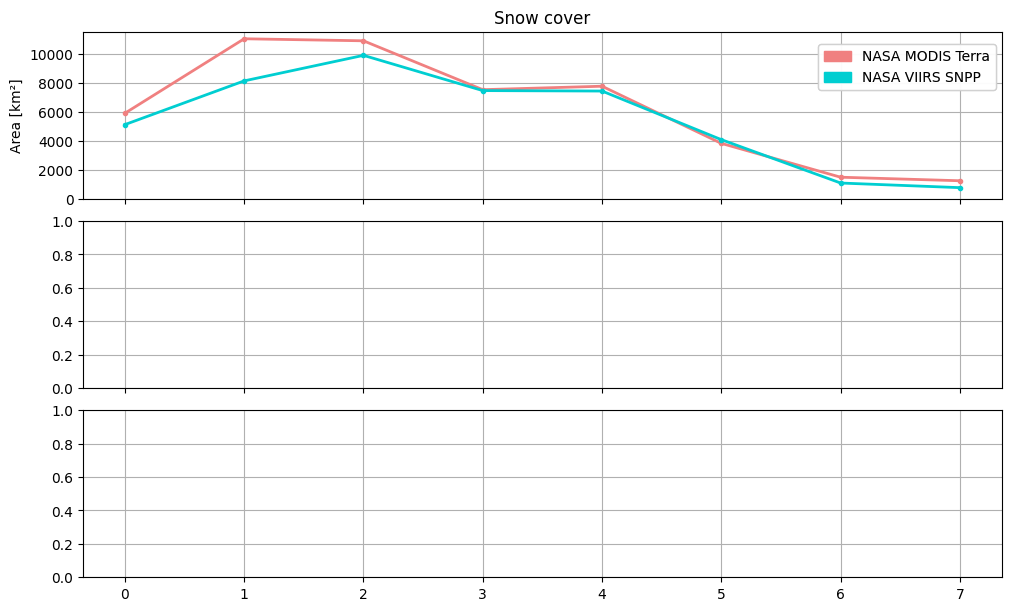

In [ ]:
from grids import UTM500mGrid
from products.snow_cover_product import MOD10A1, VNP10A1
from winter_year import WinterYear
from postprocess.general_purpose import AnalysisContainer

analysis_folder = (
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/"
)
analysis = AnalysisContainer(products=[MOD10A1(), VNP10A1()], analysis_folder=analysis_folder,winter_year=WinterYear(2023, 2024), grid=UTM500mGrid())

n_classes = len(classes)
n_scores = len(scores)
n_tot = n_classes + n_scores
fig, axs = plt.subplots(n_tot, figsize=(10, 2*n_tot) , sharex=True, layout="constrained")

annual_area_fancy_plot(analysis=analysis, classes=['snow_cover'], scores=['rmse', 'biais'])



/tmp/ipykernel_13585/2899259277.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


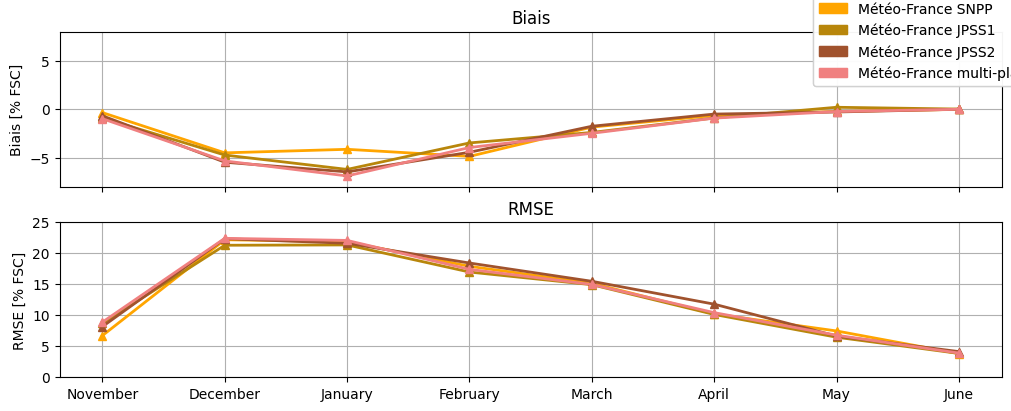

In [43]:
from products.snow_cover_product import MeteoFranceEvalSNPP, MeteoFranceEvalJPSS1, MeteoFranceEvalJPSS2, MeteoFranceComposite
from matplotlib import pyplot as plt
from winter_year import WinterYear
from grids import UTM375mGrid

analysis_folder = '/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/'
product_list = [MeteoFranceEvalSNPP(),MeteoFranceEvalJPSS1(),  MeteoFranceEvalJPSS2(),MeteoFranceComposite()]
analysis = AnalysisContainer(products=product_list, analysis_folder=analysis_folder,winter_year=WinterYear(2024, 2025), grid=UTM375mGrid())

# plt.subplots_adjust(bottom=0.18)
# fig, axs = plt.subplots(3, 1, figsize=(12, 7))
fig_plotted = annual_area_fancy_plot(analysis=analysis, classes=[], scores=['biais','rmse'])
fig_plotted.savefig('/home/imperatoren/work/VIIRS_S2_comparison/article/multiplatform_composite_2024_2025.png', format='png',bbox_inches='tight')

In [1]:
import xarray as xr

ds = xr.open_dataset('/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/analyses/completeness/completeness_WY_2023_2024_nasa_l3_snpp.nc')
ds= ds.sel(time=slice('2023-11', '2024-06'))
snow_cover = ds.data_vars['surface'].sel(class_name='snow_cover').sum(dim=('altitude_bins', 'time', 'forest_mask_bins')).values
total = ds.data_vars['surface'].sel(class_name=['snow_cover', 'no_snow', 'water']).sum().values
print("Snow cover percentage of valid observations for the study area")
print(snow_cover/total*100)

ds = xr.open_dataset('/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/analyses/completeness/completeness_WY_2023_2024_nasa_l3_snpp.nc')
ds= ds.sel(altitude_bins=slice(900,None), time=slice('2023-11', '2024-06'))
snow_cover = ds.data_vars['surface'].sel(class_name='snow_cover').sum(dim=('altitude_bins', 'time', 'forest_mask_bins')).values
total = ds.data_vars['surface'].sel(class_name=['snow_cover', 'no_snow', 'water']).sum().values
print("Snow cover percentage of valid observations for the study area with 900 m altitude threshold")
print(snow_cover/total*100)

snow_cover_forest = ds.data_vars['surface'].sel(class_name='snow_cover', forest_mask_bins='forest').sum(dim=('altitude_bins', 'time')).values
total = ds.data_vars['surface'].sel(class_name=['snow_cover', 'no_snow', 'water'], forest_mask_bins='forest').sum().values
print("Snow cover percentage of valid observations for the study area with 900 m altitude threshold in open areas")
print(snow_cover_forest/total*100)

snow_cover_no_forest = ds.data_vars['surface'].sel(class_name='snow_cover', forest_mask_bins='no_forest').sum(dim=('altitude_bins', 'time')).values
total = ds.data_vars['surface'].sel(class_name=['snow_cover', 'no_snow', 'water'], forest_mask_bins='no_forest').sum().values
print("Snow cover percentage of valid observations for the study area with 900 m altitude threshold in forest areas")
print(snow_cover/total*100)

Snow cover percentage of valid observations for the study area
20.564300068700177
Snow cover percentage of valid observations for the study area with 900 m altitude threshold
31.431908768832695
Snow cover percentage of valid observations for the study area with 900 m altitude threshold in open areas
21.59747756081099
Snow cover percentage of valid observations for the study area with 900 m altitude threshold in forest areas
56.96711507773282


In [33]:
import xarray as xr

ds_snpp = xr.open_dataset('/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/analyses/completeness/completeness_WY_2023_2024_meteofrance_prototype_snpp.nc')
ds_jpss1 = xr.open_dataset('/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/analyses/completeness/completeness_WY_2023_2024_meteofrance_prototype_jpss1.nc')
ds_multiplatform = xr.open_dataset('/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/analyses/completeness/completeness_WY_2023_2024_meteofrance_prototype_multiplatform.nc')

clouds_snpp = ds_snpp.data_vars['surface'].sel(class_name='clouds').sum(dim=('altitude_bins', 'time', 'forest_mask_bins')).values
clouds_jpss1 = ds_jpss1.data_vars['surface'].sel(class_name='clouds').sum(dim=('altitude_bins', 'time','forest_mask_bins')).values
clouds_multiplatform = ds_multiplatform.data_vars['surface'].sel(class_name='clouds').sum(dim=('altitude_bins', 'time')).values

print("Cloud cover reduction from SNPP to multiplatform")
print((clouds_snpp - clouds_multiplatform)/clouds_snpp * 100)
print("Cloud cover reduction from JPSS-1 to multiplatform")
print((clouds_jpss1 - clouds_multiplatform)/clouds_jpss1 *100)

Cloud cover reduction from SNPP to multiplatform
8.885516284916674
Cloud cover reduction from JPSS-1 to multiplatform
11.43227173877166


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from pandas.io.formats.style import Styler

from postprocess.error_distribution import compute_uncertainty_results_df
from postprocess.general_purpose import fancy_table,open_reduced_dataset
from postprocess.skill_scores import compute_contingency_results_df, compute_n_pixels_results_df
from products.snow_cover_product import VJ110A1, VNP10A1, MeteoFranceEvalSNPP, SnowCoverProduct
# import dataframe_image as dfi

from IPython.display import display

from products.snow_cover_product import VNP10A1




def fancy_table_tot(dataframe_to_print: pd.DataFrame) -> Styler:
    # Get the built-in RdYlGn colormap
    base_cmap = plt.get_cmap("RdYlGn")

    # Sample the three anchor colors from RdYlGn:
    red = base_cmap(0.0)  # left end
    yellow = base_cmap(0.5)  # center (yellow in RdYlGn)
    green = base_cmap(1.0)  # right end
    colors_biais = [red, yellow, green, yellow, red]

    cmap_biais = LinearSegmentedColormap.from_list("green_center", colors_biais, N=256)
    color_maps = {
        "Accuracy": "RdYlGn",
        "F1-score": "RdYlGn",
        "Commission Error": "RdYlGn_r",  # Lower is better
        "Omission Error": "RdYlGn_r",
        "Bias [%]": cmap_biais,
        "RMSE [%]": "RdYlGn_r",
    }
    vmins = {
        "Accuracy": 0.6,  # Higher is better
        "F1-score": 0.6,
        "Commission Error": 0,  # Lower is better (reversed Reds)
        "Omission Error": 0,
        "Bias [%]": -5,
        "RMSE [%]": 5,
    }
    vmaxs = {
        "Accuracy": 1,  # Higher is better
        "F1-score": 1,
        "Commission Error": 0.3,  # Lower is better
        "Omission Error": 0.3,
        "Bias [%]": 5,
        "RMSE [%]": 30,
    }

    # Build the colormap

    # Apply gradient coloring
    return fancy_table(dataframe_to_print=dataframe_to_print, color_maps=color_maps, vmins=vmins, vmaxs=vmaxs)


analysis_folder = "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/"

product_list = [VNP10A1()]
winter_year = WinterYear(2023,2024)

df_list = []

refs = ['1-99 \%', '0-100 \%']

for i, ref in enumerate([slice(25, 100), slice(None, None)]):
    for f in ["forest", "no_forest"]:
        for asp in ["N", "S"]:
            # for t in [ '2023-12',  '2024-04']:
            # print(f,asp,ref)
            selection = dict(altitude_bins=slice(900, None), ref_bins=ref, forest_mask_bins=f, aspect_bins=asp)
            uncertainty_list = [
                open_reduced_dataset(prod, analysis_folder=analysis_folder, analysis_type="uncertainty", winter_year=winter_year).sel(selection)
                for prod in product_list
            ]
            confusion_table_list = [
                open_reduced_dataset(prod, analysis_folder=analysis_folder, analysis_type="confusion_table", winter_year=winter_year).sel(selection)
                for prod in product_list
            ]
            df_cont = compute_contingency_results_df(snow_cover_products=product_list, metric_datasets=confusion_table_list)
            df_cont["Reference FSC"] = refs[i]
            df_unc = compute_uncertainty_results_df(snow_cover_products=product_list, metric_datasets=uncertainty_list)[
                ["biais", "rmse"]
            ]
            df_n_pixels = compute_n_pixels_results_df(snow_cover_products=product_list, metric_datasets=confusion_table_list)[
                ["n_tot_pixels", "n_snow_pixels"]
            ]
            df_n_pixels["percentage_snow_pixels"] = df_n_pixels["n_snow_pixels"] / df_n_pixels["n_tot_pixels"] * 100
            df_n_pixels = df_n_pixels[["n_tot_pixels", "percentage_snow_pixels"]]

            df_tot = pd.concat(
                [
                    df_cont[["Reference FSC", "forest_mask_bins", "aspect_bins"]],
                    df_n_pixels,
                    df_cont[["accuracy", "f1_score", "commission_error", "omission_error"]],
                    df_unc,
                ],
                axis=1,
            )

            df_tot = df_tot.rename(
                columns={
                    "forest_mask_bins": "Landcover",
                    "aspect_bins": "Aspect",
                    "n_tot_pixels": "N pixels",
                    "percentage_snow_pixels": "% Snow Cover",
                    "accuracy": "Accuracy",
                    "f1_score": "F1-score",
                    "commission_error": "Commission Error",
                    "omission_error": "Omission Error",
                    "biais": "Bias [%]",
                    "rmse": "RMSE [%]",
                }
            )

            if df_tot.loc[0, "Landcover"] == "forest":
                df_tot["Landcover"] = "Forest"
            elif df_tot.loc[0, "Landcover"] == "no_forest":
                df_tot["Landcover"] = "Open"
            df_list.append(df_tot)
            # print(df_tot)
            # print("Worse")
            # fancy_table_skill_scores(df)


df_resume = pd.concat(df_list, ignore_index=True)
styled = fancy_table_tot(df_resume)

print("VNP10A1 2023/2024")
display(styled)
# dfi.export(styled, "/home/imperatoren/work/VIIRS_S2_comparison/article/illustrations/table_vnp10a1.pdf", table_conversion="selenium") 


<>:68: SyntaxWarning: invalid escape sequence '\%'
<>:68: SyntaxWarning: invalid escape sequence '\%'
<>:68: SyntaxWarning: invalid escape sequence '\%'
<>:68: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_5854/2955592664.py:68: SyntaxWarning: invalid escape sequence '\%'
  refs = ['1-99 \%', '0-100 \%']
/tmp/ipykernel_5854/2955592664.py:68: SyntaxWarning: invalid escape sequence '\%'
  refs = ['1-99 \%', '0-100 \%']


VNP10A1 2023/2024


Reference FSC,Landcover,Aspect,N pixels,% Snow Cover,Accuracy,F1-score,Commission Error,Omission Error,Bias [%],RMSE [%]
1-99 \%,Forest,N,5.04e+04,44.10,0.78,0.74,0.17,0.29,-5.11,30.08
1-99 \%,Forest,S,1.29e+04,47.08,0.85,0.84,0.11,0.19,-5.32,22.36
1-99 \%,Open,N,1.04e+05,80.88,0.92,0.95,0.12,0.08,-4.15,19.05
1-99 \%,Open,S,8.34e+04,76.42,0.95,0.97,0.11,0.03,-0.38,13.89
0-100 \%,Forest,N,3.07e+05,7.25,0.96,0.73,0.02,0.29,0.06,13.18
0-100 \%,Forest,S,1.95e+05,3.11,0.99,0.83,0.00,0.19,-0.23,6.01
0-100 \%,Open,N,2.36e+05,35.74,0.96,0.95,0.02,0.08,-1.63,12.90
0-100 \%,Open,S,3.59e+05,17.75,0.99,0.97,0.01,0.03,-0.00,6.85


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from pandas.io.formats.style import Styler

from postprocess.error_distribution import compute_uncertainty_results_df
from postprocess.general_purpose import fancy_table,open_reduced_dataset
from postprocess.skill_scores import compute_contingency_results_df, compute_n_pixels_results_df
from products.snow_cover_product import VJ110A1, VNP10A1, MeteoFranceEvalSNPP, SnowCoverProduct
# import dataframe_image as dfi

from IPython.display import display

from products.snow_cover_product import VNP10A1


analysis_folder = "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/"

product_list = [VNP10A1()]
winter_year = WinterYear(2024,2025)

df_list = []

refs = ['1-99 \%', '0-100 \%']

for i, ref in enumerate([slice(25, 100), slice(None, None)]):
    for f in ["forest", "no_forest"]:
        for asp in ["N", "S"]:
            # for t in [ '2023-12',  '2024-04']:
            # print(f,asp,ref)
            selection = dict(altitude_bins=slice(900, None), ref_bins=ref, forest_mask_bins=f, aspect_bins=asp)
            uncertainty_list = [
                open_reduced_dataset(prod, analysis_folder=analysis_folder, analysis_type="uncertainty", winter_year=winter_year).sel(selection)
                for prod in product_list
            ]
            confusion_table_list = [
                open_reduced_dataset(prod, analysis_folder=analysis_folder, analysis_type="confusion_table", winter_year=winter_year).sel(selection)
                for prod in product_list
            ]
            df_cont = compute_contingency_results_df(snow_cover_products=product_list, metric_datasets=confusion_table_list)
            df_cont["Reference FSC"] = refs[i]
            df_unc = compute_uncertainty_results_df(snow_cover_products=product_list, metric_datasets=uncertainty_list)[
                ["biais", "rmse"]
            ]
            df_n_pixels = compute_n_pixels_results_df(snow_cover_products=product_list, metric_datasets=confusion_table_list)[
                ["n_tot_pixels", "n_snow_pixels"]
            ]
            df_n_pixels["percentage_snow_pixels"] = df_n_pixels["n_snow_pixels"] / df_n_pixels["n_tot_pixels"] * 100
            df_n_pixels = df_n_pixels[["n_tot_pixels", "percentage_snow_pixels"]]

            df_tot = pd.concat(
                [
                    df_cont[["Reference FSC", "forest_mask_bins", "aspect_bins"]],
                    df_n_pixels,
                    df_cont[["accuracy", "f1_score", "commission_error", "omission_error"]],
                    df_unc,
                ],
                axis=1,
            )

            df_tot = df_tot.rename(
                columns={
                    "forest_mask_bins": "Landcover",
                    "aspect_bins": "Aspect",
                    "n_tot_pixels": "N pixels",
                    "percentage_snow_pixels": "% Snow Cover",
                    "accuracy": "Accuracy",
                    "f1_score": "F1-score",
                    "commission_error": "Commission Error",
                    "omission_error": "Omission Error",
                    "biais": "Bias [%]",
                    "rmse": "RMSE [%]",
                }
            )

            if df_tot.loc[0, "Landcover"] == "forest":
                df_tot["Landcover"] = "Forest"
            elif df_tot.loc[0, "Landcover"] == "no_forest":
                df_tot["Landcover"] = "Open"
            df_list.append(df_tot)
            # print(df_tot)
            # print("Worse")
            # fancy_table_skill_scores(df)


df_resume = pd.concat(df_list, ignore_index=True)
styled = fancy_table_tot(df_resume)

print("VNP10A1 2024/2025")
display(styled)
# dfi.export(styled, "/home/imperatoren/work/VIIRS_S2_comparison/article/illustrations/table_vnp10a1.pdf", table_conversion="selenium") 


<>:24: SyntaxWarning: invalid escape sequence '\%'
<>:24: SyntaxWarning: invalid escape sequence '\%'
<>:24: SyntaxWarning: invalid escape sequence '\%'
<>:24: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_5854/2299743903.py:24: SyntaxWarning: invalid escape sequence '\%'
  refs = ['1-99 \%', '0-100 \%']
/tmp/ipykernel_5854/2299743903.py:24: SyntaxWarning: invalid escape sequence '\%'
  refs = ['1-99 \%', '0-100 \%']


VNP10A1 2024/2025


Reference FSC,Landcover,Aspect,N pixels,% Snow Cover,Accuracy,F1-score,Commission Error,Omission Error,Bias [%],RMSE [%]
1-99 \%,Forest,N,1.07e+05,44.07,0.77,0.73,0.18,0.30,-5.14,32.42
1-99 \%,Forest,S,3.79e+04,41.18,0.86,0.82,0.08,0.21,-6.54,22.97
1-99 \%,Open,N,1.60e+05,77.49,0.90,0.93,0.11,0.09,-5.21,21.73
1-99 \%,Open,S,1.25e+05,70.71,0.95,0.96,0.06,0.05,-2.78,16.38
0-100 \%,Forest,N,6.06e+05,7.80,0.96,0.72,0.02,0.30,0.10,14.70
0-100 \%,Forest,S,3.78e+05,4.12,0.99,0.82,0.01,0.21,-0.53,7.48
0-100 \%,Open,N,4.45e+05,27.82,0.96,0.93,0.01,0.09,-1.67,13.29
0-100 \%,Open,S,6.50e+05,13.56,0.99,0.96,0.00,0.05,-0.44,7.34


In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from pandas.io.formats.style import Styler

from postprocess.error_distribution import compute_uncertainty_results_df
from postprocess.general_purpose import fancy_table,open_reduced_dataset
from postprocess.skill_scores import compute_contingency_results_df, compute_n_pixels_results_df
from products.snow_cover_product import VJ110A1, VNP10A1, MeteoFranceEvalSNPP, SnowCoverProduct, MeteoFrancePrototypeSNPP
# import dataframe_image as dfi

from IPython.display import display

from products.snow_cover_product import VNP10A1


analysis_folder = "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/"

product_list = [MeteoFranceEvalSNPP()]
winter_year = WinterYear(2024,2025)

df_list = []

refs = ['1-99 \%', '0-100 \%']

for i, ref in enumerate([slice(25, 100), slice(None, None)]):
    for f in ["forest", "no_forest"]:
        for asp in ["N", "S"]:
            # for t in [ '2023-12',  '2024-04']:
            # print(f,asp,ref)
            selection = dict(altitude_bins=slice(900, None), ref_bins=ref, forest_mask_bins=f, aspect_bins=asp)
            uncertainty_list = [
                open_reduced_dataset(prod, analysis_folder=analysis_folder, analysis_type="uncertainty", winter_year=winter_year).sel(selection)
                for prod in product_list
            ]
            confusion_table_list = [
                open_reduced_dataset(prod, analysis_folder=analysis_folder, analysis_type="confusion_table", winter_year=winter_year).sel(selection)
                for prod in product_list
            ]
            df_cont = compute_contingency_results_df(snow_cover_products=product_list, metric_datasets=confusion_table_list)
            df_cont["Reference FSC"] = refs[i]
            df_unc = compute_uncertainty_results_df(snow_cover_products=product_list, metric_datasets=uncertainty_list)[
                ["biais", "rmse"]
            ]
            df_n_pixels = compute_n_pixels_results_df(snow_cover_products=product_list, metric_datasets=confusion_table_list)[
                ["n_tot_pixels", "n_snow_pixels"]
            ]
            df_n_pixels["percentage_snow_pixels"] = df_n_pixels["n_snow_pixels"] / df_n_pixels["n_tot_pixels"] * 100
            df_n_pixels = df_n_pixels[["n_tot_pixels", "percentage_snow_pixels"]]

            df_tot = pd.concat(
                [
                    df_cont[["Reference FSC", "forest_mask_bins", "aspect_bins"]],
                    df_n_pixels,
                    df_cont[["accuracy", "f1_score", "commission_error", "omission_error"]],
                    df_unc,
                ],
                axis=1,
            )

            df_tot = df_tot.rename(
                columns={
                    "forest_mask_bins": "Landcover",
                    "aspect_bins": "Aspect",
                    "n_tot_pixels": "N pixels",
                    "percentage_snow_pixels": "% Snow Cover",
                    "accuracy": "Accuracy",
                    "f1_score": "F1-score",
                    "commission_error": "Commission Error",
                    "omission_error": "Omission Error",
                    "biais": "Bias [%]",
                    "rmse": "RMSE [%]",
                }
            )

            if df_tot.loc[0, "Landcover"] == "forest":
                df_tot["Landcover"] = "Forest"
            elif df_tot.loc[0, "Landcover"] == "no_forest":
                df_tot["Landcover"] = "Open"
            df_list.append(df_tot)
            # print(df_tot)
            # print("Worse")
            # fancy_table_skill_scores(df)


df_resume = pd.concat(df_list, ignore_index=True)
styled = fancy_table_tot(df_resume)

print("MF 2024/2025")
display(styled)
# dfi.export(styled, "/home/imperatoren/work/VIIRS_S2_comparison/article/illustrations/table_vnp10a1.pdf", table_conversion="selenium") 


<>:24: SyntaxWarning: invalid escape sequence '\%'
<>:24: SyntaxWarning: invalid escape sequence '\%'
<>:24: SyntaxWarning: invalid escape sequence '\%'
<>:24: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_5854/1192148894.py:24: SyntaxWarning: invalid escape sequence '\%'
  refs = ['1-99 \%', '0-100 \%']
/tmp/ipykernel_5854/1192148894.py:24: SyntaxWarning: invalid escape sequence '\%'
  refs = ['1-99 \%', '0-100 \%']


MF 2024/2025


Reference FSC,Landcover,Aspect,N pixels,% Snow Cover,Accuracy,F1-score,Commission Error,Omission Error,Bias [%],RMSE [%]
1-99 \%,Forest,N,8.23e+04,47.99,0.74,0.68,0.09,0.43,-17.73,36.84
1-99 \%,Forest,S,3.10e+04,43.10,0.79,0.74,0.12,0.32,-8.58,29.00
1-99 \%,Open,N,1.49e+05,82.25,0.89,0.93,0.09,0.11,-7.66,23.97
1-99 \%,Open,S,1.30e+05,73.96,0.90,0.93,0.16,0.08,-1.79,20.43
0-100 \%,Forest,N,4.62e+05,8.55,0.95,0.68,0.01,0.43,-3.06,15.67
0-100 \%,Forest,S,2.90e+05,4.61,0.98,0.73,0.01,0.32,-0.79,9.72
0-100 \%,Open,N,3.70e+05,33.19,0.96,0.93,0.01,0.11,-3.05,15.32
0-100 \%,Open,S,5.29e+05,18.13,0.97,0.93,0.01,0.08,-0.31,10.31


In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from pandas.io.formats.style import Styler

from postprocess.error_distribution import compute_uncertainty_results_df
from postprocess.general_purpose import fancy_table,open_reduced_dataset
from postprocess.skill_scores import compute_contingency_results_df, compute_n_pixels_results_df
from products.snow_cover_product import VJ110A1, VNP10A1, MeteoFranceEvalSNPP, SnowCoverProduct, MeteoFrancePrototypeSNPP
# import dataframe_image as dfi

from IPython.display import display

from products.snow_cover_product import VNP10A1


analysis_folder = "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/"

product_list = [MeteoFrancePrototypeSNPP()]
winter_year = WinterYear(2023,2024)

df_list = []

refs = ['1-99 \%', '0-100 \%']

for i, ref in enumerate([slice(25, 100), slice(None, None)]):
    for f in ["forest", "no_forest"]:
        for asp in ["N", "S"]:
            # for t in [ '2023-12',  '2024-04']:
            # print(f,asp,ref)
            selection = dict(altitude_bins=slice(900, None), ref_bins=ref, forest_mask_bins=f, aspect_bins=asp)
            uncertainty_list = [
                open_reduced_dataset(prod, analysis_folder=analysis_folder, analysis_type="uncertainty", winter_year=winter_year).sel(selection)
                for prod in product_list
            ]
            confusion_table_list = [
                open_reduced_dataset(prod, analysis_folder=analysis_folder, analysis_type="confusion_table", winter_year=winter_year).sel(selection)
                for prod in product_list
            ]
            df_cont = compute_contingency_results_df(snow_cover_products=product_list, metric_datasets=confusion_table_list)
            df_cont["Reference FSC"] = refs[i]
            df_unc = compute_uncertainty_results_df(snow_cover_products=product_list, metric_datasets=uncertainty_list)[
                ["biais", "rmse"]
            ]
            df_n_pixels = compute_n_pixels_results_df(snow_cover_products=product_list, metric_datasets=confusion_table_list)[
                ["n_tot_pixels", "n_snow_pixels"]
            ]
            df_n_pixels["percentage_snow_pixels"] = df_n_pixels["n_snow_pixels"] / df_n_pixels["n_tot_pixels"] * 100
            df_n_pixels = df_n_pixels[["n_tot_pixels", "percentage_snow_pixels"]]

            df_tot = pd.concat(
                [
                    df_cont[["Reference FSC", "forest_mask_bins", "aspect_bins"]],
                    df_n_pixels,
                    df_cont[["accuracy", "f1_score", "commission_error", "omission_error"]],
                    df_unc,
                ],
                axis=1,
            )

            df_tot = df_tot.rename(
                columns={
                    "forest_mask_bins": "Landcover",
                    "aspect_bins": "Aspect",
                    "n_tot_pixels": "N pixels",
                    "percentage_snow_pixels": "% Snow Cover",
                    "accuracy": "Accuracy",
                    "f1_score": "F1-score",
                    "commission_error": "Commission Error",
                    "omission_error": "Omission Error",
                    "biais": "Bias [%]",
                    "rmse": "RMSE [%]",
                }
            )

            if df_tot.loc[0, "Landcover"] == "forest":
                df_tot["Landcover"] = "Forest"
            elif df_tot.loc[0, "Landcover"] == "no_forest":
                df_tot["Landcover"] = "Open"
            df_list.append(df_tot)
            # print(df_tot)
            # print("Worse")
            # fancy_table_skill_scores(df)


df_resume = pd.concat(df_list, ignore_index=True)
styled = fancy_table_tot(df_resume)

print("MF 2023/2024")
display(styled)
# dfi.export(styled, "/home/imperatoren/work/VIIRS_S2_comparison/article/illustrations/table_vnp10a1.pdf", table_conversion="selenium") 


<>:24: SyntaxWarning: invalid escape sequence '\%'
<>:24: SyntaxWarning: invalid escape sequence '\%'
<>:24: SyntaxWarning: invalid escape sequence '\%'
<>:24: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_5854/1595163815.py:24: SyntaxWarning: invalid escape sequence '\%'
  refs = ['1-99 \%', '0-100 \%']
/tmp/ipykernel_5854/1595163815.py:24: SyntaxWarning: invalid escape sequence '\%'
  refs = ['1-99 \%', '0-100 \%']


MF 2023/2024


Reference FSC,Landcover,Aspect,N pixels,% Snow Cover,Accuracy,F1-score,Commission Error,Omission Error,Bias [%],RMSE [%]
1-99 \%,Forest,N,7.08e+04,52.54,0.79,0.79,0.16,0.25,-6.68,29.56
1-99 \%,Forest,S,2.27e+04,56.69,0.82,0.84,0.15,0.20,-5.10,25.25
1-99 \%,Open,N,1.42e+05,84.25,0.91,0.94,0.13,0.08,-4.81,20.66
1-99 \%,Open,S,1.23e+05,75.81,0.90,0.94,0.19,0.06,-0.66,18.82
0-100 \%,Forest,N,3.41e+05,10.90,0.96,0.78,0.02,0.25,-2.92,24.28
0-100 \%,Forest,S,2.14e+05,6.02,0.98,0.83,0.01,0.20,-1.35,17.62
0-100 \%,Open,N,2.78e+05,42.93,0.95,0.94,0.02,0.08,-2.46,15.48
0-100 \%,Open,S,4.11e+05,22.73,0.97,0.93,0.02,0.06,0.05,11.07


In [49]:
df_resume_latex = df_resume.rename(columns={'% Snow Cover': '\% Snow Cover', 'Bias [%]':'Bias [\%]', 'RMSE [%]':'RMSE [\%]'})

def highlight_closest_to_zero(s):
    # find index of value with minimum absolute value
    idx_min = (s.abs()).idxmin()
    # build style list
    return ['font-weight: bold;' if i == idx_min else '' for i in s.index]


styled = df_resume_latex.style.highlight_max(
    subset=['Accuracy', 'F1-score'], props="font-weight:bold;").highlight_min(
        subset=['Commission Error', 'Omission Error', 'RMSE [\%]'], props="font-weight:bold;").apply(
            highlight_closest_to_zero, subset=['Bias [\%]'])

styled = styled.format(
            {"N pixels": "{:.2e}".format,
             '\% Snow Cover': "{:.2e}".format,
             "Accuracy": "{:.2f}".format,
             "F1-score": "{:.2f}".format,
             "Commission Error": "{:.2f}".format,
             "Omission Error": "{:.2f}".format,
             "Bias [\%]": "{:.2f}".format,
             "RMSE [\%]": "{:.2f}".format,
             }
        )
latex_str = styled.hide(axis="index").to_latex(hrules=True, convert_css=True)
print(latex_str)

\begin{tabular}{lllrrrrrrrr}
\toprule
Reference FSC & Landcover & Aspect & N pixels & \% Snow Cover & Accuracy & F1-score & Commission Error & Omission Error & Bias [\%] & RMSE [\%] \\
\midrule
1-99 \% & Forest & N & 5.04e+04 & 4.41e+01 & 0.78 & 0.74 & 0.17 & 0.29 & -5.11 & 30.08 \\
1-99 \% & Forest & S & 1.29e+04 & 4.71e+01 & 0.85 & 0.84 & 0.11 & 0.19 & -5.32 & 22.36 \\
1-99 \% & Open & N & 1.04e+05 & 8.09e+01 & 0.92 & 0.95 & 0.12 & 0.08 & -4.15 & 19.05 \\
1-99 \% & Open & S & 8.34e+04 & 7.64e+01 & 0.95 & \bfseries 0.97 & 0.11 & \bfseries 0.03 & -0.38 & 13.89 \\
0-100 \% & Forest & N & 3.07e+05 & 7.25e+00 & 0.96 & 0.73 & 0.02 & 0.29 & 0.06 & 13.18 \\
0-100 \% & Forest & S & 1.95e+05 & 3.11e+00 & \bfseries 0.99 & 0.83 & \bfseries 0.00 & 0.19 & -0.23 & \bfseries 6.01 \\
0-100 \% & Open & N & 2.36e+05 & 3.57e+01 & 0.96 & 0.95 & 0.02 & 0.08 & -1.63 & 12.90 \\
0-100 \% & Open & S & 3.59e+05 & 1.77e+01 & 0.99 & 0.97 & 0.01 & \bfseries 0.03 & \bfseries -0.00 & 6.85 \\
\bottomrule
\end{tabula

<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:12: SyntaxWarning: invalid escape sequence '\%'
<>:13: SyntaxWarning: invalid escape sequence '\%'
<>:17: SyntaxWarning: invalid escape sequence '\%'
<>:22: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\%'
<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:12: SyntaxWarning: invalid escape sequence '\%'
<>:13: SyntaxWarning: invalid escape sequence '\%'
<>:17: SyntaxWarning: invalid escape sequence '\%'
<>:22: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_8689/618400364.py:1: SyntaxWarning: invalid escape sequence '\%'
  df_resume_latex = df_resume.rename(columns={'% Snow Cover': '\% Snow Cover', 'Bias [%]':'Bias [\%]', 'RMSE [

In [12]:
from typing import  List

import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from pandas.io.formats.style import Styler

from postprocess.error_distribution import compute_uncertainty_results_df
from postprocess.general_purpose import  open_reduced_dataset, fancy_table
from postprocess.skill_scores import compute_contingency_results_df, compute_n_pixels_results_df
from products.snow_cover_product import VJ110A1, VNP10A1, MeteoFrancePrototypeSNPP, SnowCoverProduct
# import dataframe_image as dfi
from matplotlib.colors import LinearSegmentedColormap

import numpy as np
from IPython.display import display

from products.snow_cover_product import VNP10A1



def fancy_table_tot(dataframe_to_print: pd.DataFrame) -> Styler:
    # Get the built-in RdYlGn colormap
    base_cmap = plt.get_cmap("RdYlGn")

    # Sample the three anchor colors from RdYlGn:
    red = base_cmap(0.0)  # left end
    yellow = base_cmap(0.5)  # center (yellow in RdYlGn)
    green = base_cmap(1.0)  # right end
    colors_biais = [red, yellow, green, yellow, red]

    cmap_biais = LinearSegmentedColormap.from_list("green_center", colors_biais, N=256)
    color_maps = {
        "Accuracy": "RdYlGn",
        "F1-score": "RdYlGn",
        "Commission Error": "RdYlGn_r",  # Lower is better
        "Omission Error": "RdYlGn_r",
        "Bias [%]": cmap_biais,
        "RMSE [%]": "RdYlGn_r",
    }
    vmins = {
        "Accuracy": 0.6,  # Higher is better
        "F1-score": 0.6,
        "Commission Error": 0,  # Lower is better (reversed Reds)
        "Omission Error": 0,
        "Bias [%]": -5,
        "RMSE [%]": 5,
    }
    vmaxs = {
        "Accuracy": 1,  # Higher is better
        "F1-score": 1,
        "Commission Error": 0.3,  # Lower is better
        "Omission Error": 0.3,
        "Bias [%]": 5,
        "RMSE [%]": 30,
    }

    # Build the colormap

    # Apply gradient coloring
    return fancy_table(dataframe_to_print=dataframe_to_print, color_maps=color_maps, vmins=vmins, vmaxs=vmaxs)


analysis_folder = "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/"

product_list = [VNP10A1(),  MeteoFranceEvalSNPP()]
winter_year = WinterYear(2024,2025)
# refs = ['1-99', '0-100']

df_list = []
selection = dict(altitude_bins=slice(900, None))
uncertainty_list = [
    open_reduced_dataset(prod, analysis_folder=analysis_folder, analysis_type="uncertainty", winter_year=winter_year).sel(selection)
    for prod in product_list
]
confusion_table_list = [
    open_reduced_dataset(prod, analysis_folder=analysis_folder, analysis_type="confusion_table",winter_year=winter_year).sel(selection)
    for prod in product_list
]
df_cont = compute_contingency_results_df(snow_cover_products=product_list, metric_datasets=confusion_table_list)
# df_cont["Reference"] = refs[i]
df_unc = compute_uncertainty_results_df(snow_cover_products=product_list, metric_datasets=uncertainty_list)[
    ["biais", "rmse"]
]
df_n_pixels = compute_n_pixels_results_df(snow_cover_products=product_list, metric_datasets=confusion_table_list)[
    ["n_tot_pixels", "n_snow_pixels"]
]
df_n_pixels["percentage_snow_pixels"] = df_n_pixels["n_snow_pixels"] / df_n_pixels["n_tot_pixels"] * 100
df_n_pixels = df_n_pixels[["n_tot_pixels", "percentage_snow_pixels"]]

df_tot = pd.concat(
    [
        df_cont[["product"]],
        df_n_pixels,
        df_cont[["accuracy", "f1_score", "commission_error", "omission_error"]],
        df_unc,
    ],
    axis=1,
)


df_tot = df_tot.rename(
    columns={
        "product": "Product",
        "n_tot_pixels": "N pixels",
        "percentage_snow_pixels": "% Snow Cover",
        "accuracy": "Accuracy",
        "f1_score": "F1-score",
        "commission_error": "Commission Error",
        "omission_error": "Omission Error",
        "biais": "Bias [%]",
        "rmse": "RMSE [%]",
    }
)


df_list.append(df_tot)



df_resume = pd.concat(df_list, ignore_index=True)
df_resume=df_resume.replace("NASA VIIRS SNPP", "VNP10A1")
df_resume=df_resume.replace("NASA VIIRS JPSS1", "VJ110A1")
df_resume=df_resume.replace("Météo-France prototype SNPP", "MF FSC L3 SNPP")

styled = fancy_table_tot(df_resume)

display(styled)
# dfi.export(styled, "/home/imperatoren/work/VIIRS_S2_comparison/article/illustrations/table_multiproduct.pdf", table_conversion="selenium") 


Product,N pixels,% Snow Cover,Accuracy,F1-score,Commission Error,Omission Error,Bias [%],RMSE [%]
VNP10A1,8.49e+06,14.34,0.98,0.91,0.01,0.10,-0.34,10.48
Météo-France SNPP,6.78e+06,17.12,0.97,0.89,0.01,0.14,-1.38,12.61


In [ ]:
df_resume_latex = df_resume.rename(columns={'% Snow Cover': '\% Snow Cover', 'Bias [%]':'Bias [\%]', 'RMSE [%]':'RMSE [\%]'})

def highlight_closest_to_zero(s):
    # find index of value with minimum absolute value
    idx_min = (s.abs()).idxmin()
    # build style list
    return ['font-weight: bold;' if i == idx_min else '' for i in s.index]


styled = df_resume_latex.style.highlight_max(
    subset=['Accuracy', 'F1-score'], props="font-weight:bold;").highlight_min(
        subset=['Commission Error', 'Omission Error', 'RMSE [\%]'], props="font-weight:bold;").apply(
            highlight_closest_to_zero, subset=['Bias [\%]'])

styled = styled.format(
            {"N pixels": "{:.2e}".format,
             '\% Snow Cover': "{:.2f}".format,
             "Accuracy": "{:.2f}".format,
             "F1-score": "{:.2f}".format,
             "Commission Error": "{:.2f}".format,
             "Omission Error": "{:.2f}".format,
             "Bias [\%]": "{:.2f}".format,
             "RMSE [\%]": "{:.2f}".format,
             }
        )
latex_str = styled.hide(axis="index").to_latex(hrules=True, convert_css=True)
print(latex_str)

\begin{tabular}{lrrrrrrrr}
\toprule
Product & N pixels & \% Snow Cover & Accuracy & F1-score & Commission Error & Omission Error & Bias [\%] & RMSE [\%] \\
\midrule
VNP10A1 & 4.33e+06 & 1.77e+01 & \bfseries 0.98 & \bfseries 0.93 & \bfseries 0.01 & 0.07 & -0.16 & \bfseries 9.72 \\
VJ110A1 & 4.45e+06 & 1.86e+01 & 0.97 & 0.93 & 0.02 & \bfseries 0.07 & \bfseries 0.10 & 10.68 \\
MF FSC L3 SNPP & 4.89e+06 & 2.25e+01 & 0.96 & 0.92 & 0.02 & 0.10 & -0.96 & 14.79 \\
\bottomrule
\end{tabular}



<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:12: SyntaxWarning: invalid escape sequence '\%'
<>:13: SyntaxWarning: invalid escape sequence '\%'
<>:17: SyntaxWarning: invalid escape sequence '\%'
<>:22: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\%'
<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:12: SyntaxWarning: invalid escape sequence '\%'
<>:13: SyntaxWarning: invalid escape sequence '\%'
<>:17: SyntaxWarning: invalid escape sequence '\%'
<>:22: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_8689/618400364.py:1: SyntaxWarning: invalid escape sequence '\%'
  df_resume_latex = df_resume.rename(columns={'% Snow Cover': '\% Snow Cover', 'Bias [%]':'Bias [\%]', 'RMSE [

In [ ]:
def smart_format(x):
    # small or large numbers → scientific
    if type(x) is str:
        return x
    if abs(x) >= 1e4 or (abs(x) > 0 and abs(x) < 0.001):
        return f"{x:.2e}"
    else:
        return f"{x:.2f}"
print(df_resume.style.highlight_max(axis=0, props="font-weight:bold;").to_latex(convert_css=True))

\begin{tabular}{llrrrrrrrr}
 & Product & # of pixels & % Snow Cover & Accuracy & F1-score & Commission error & Omission error & Bias [%] & RMSE [%] \\
0 & \font-weightbold VNP10A1 & 4332262.000000 & 17.716726 & \font-weightbold 0.975986 & \font-weightbold 0.931798 & 0.013240 & 0.074055 & -0.160604 & 9.716649 \\
1 & VJ110A1 & 4450148.000000 & 18.561023 & 0.973512 & 0.928546 & 0.015939 & 0.072771 & \font-weightbold 0.103983 & 10.684348 \\
2 & Météo-France prototype SNPP & \font-weightbold 4891374.000000 & \font-weightbold 22.541437 & 0.963850 & 0.918454 & \font-weightbold 0.018478 & \font-weightbold 0.096873 & -0.962117 & \font-weightbold 14.793209 \\
\end{tabular}

